In [370]:
import numpy as np

import cv2
import matplotlib.pyplot as plt
import pandas as pd

import scipy
from scipy.interpolate import CubicSpline, lagrange
from scipy.optimize import curve_fit

from numpy.polynomial.polynomial import Polynomial
import random
import os
from skimage.draw import line
from scipy.ndimage import gaussian_filter1d
import skimage.morphology as morphology


import torch
from torch.distributions.gamma import Gamma

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from Solver import *
# from src.ImageClass import *
# from all import *
# from transform import *
# from draw import *

cpu


In [371]:
def generate_square_image(mask_w, mask_h, radius, border_width):
    square_image = 255*np.zeros((mask_w, mask_h), dtype=np.uint8) # blank image
    center = (mask_w//2, mask_h//2)

    square_image = cv2.rectangle(square_image, (center[0] - (radius-10), center[1]-(radius-10)), 
                (center[0] + (radius-10), center[1]+ (radius-10)), 255, 20) 
    square_image = cv2.rectangle(square_image, (center[0] - (radius-10), center[1]-(radius-10)), 
                (center[0] + (radius-10), center[1]+ (radius-10)), 255, -1)
    # added
    cont, _ = cv2.findContours(square_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    square_image = 255*np.zeros((mask_w, mask_h), dtype=np.uint8) # blank image
    cv2.drawContours(square_image, cont, 0, 128, border_width*2)
    square_image = cv2.rectangle(square_image, (center[0] - (radius-10), center[1]-(radius-10)), 
                (center[0] + (radius-10), center[1]+ (radius-10)), 255, 20) 
    square_image = cv2.rectangle(square_image, (center[0] - (radius-10), center[1]-(radius-10)), 
                (center[0] + (radius-10), center[1]+ (radius-10)), 255, -1)

    plt.imshow(square_image)
    return square_image

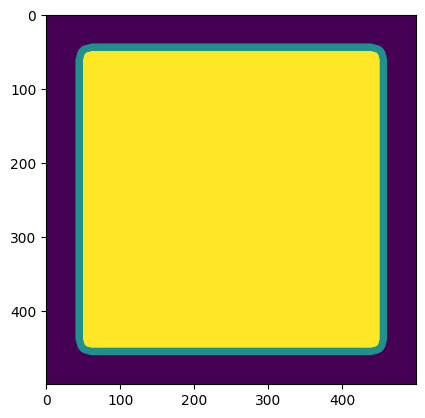

In [372]:
square_image = generate_square_image(500,500, 200, 10)

In [373]:
len(np.argwhere(square_image[250,:] == 255))-1

400

In [473]:
resist_thickness = 700
silicon_thickness = 100
pixel_size = 12
transform_algo = 'bezier'
algo = 'algo1'
k_value = 0.125
E_value = 10
signal_formula = 'formula_e'


flag_render_circle = 'horizontally'
flag_render_square = 'horizontally'

dp3 = (0, 1)
dp2 = (1, 0)

In [549]:
solv = Solver(algo=algo, signal_formula = signal_formula, pixel_size=pixel_size, \
                      resist_thickness=resist_thickness, k=k_value, E=E_value, masks = [square_image],\
                        recalculate=True, dp2=dp2, dp3=dp3)

Processing time: 1.371523380279541 [sec]


True

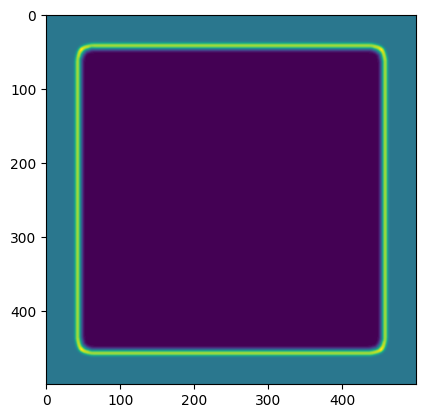

In [550]:
plt.imshow(solv.mask_objects[0].signal)

cv2.imwrite('./signal_square_original.png', solv.mask_objects[0].signal.astype(np.uint8))

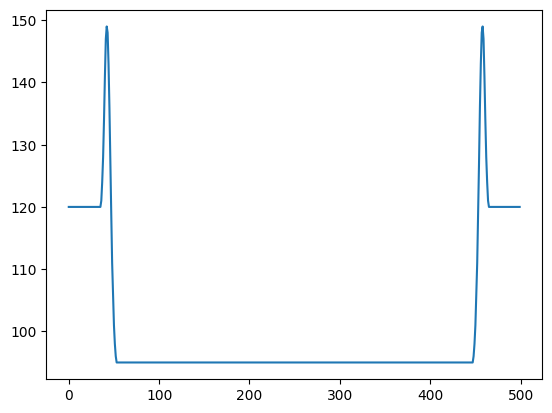

In [377]:
plt.plot(solv.mask_objects[0].signal[250,:])

### Считаем длины полосок белого, чтобы определить, широкая фигура или нет

In [378]:
def hole_width(mask):
    # можно делать более оптмизированно
    # для одного объекта брать индекс начала белой области 
    # и затем всей белой области в этой полоске присваивать длину белой области
    row_width = np.zeros_like(mask, dtype=np.uint8)
    for row in range(mask.shape[0]):
        white_pixels = np.argwhere(mask[row,:] == 255)
        for pixel in white_pixels:
            if mask[row,pixel]==255 and mask[row,pixel-1] == 128:
                start = pixel
            elif mask[row,pixel]==255 and mask[row,pixel+1] == 128:
                end = pixel
                row_width[row, start[0]:end[0]+1] = len(row_width[row, start[0]:end[0]])


    column_width = np.zeros_like(mask, dtype=np.uint8)
    for col in range(mask.shape[1]):
        white_pixels = np.argwhere(mask[:,col] == 255)
        for pixel in white_pixels:
            if mask[pixel, col] == 255 and mask[pixel-1, col] == 128:
                start = pixel
            elif mask[pixel, col] == 255 and mask[pixel+1, col] == 128:
                end = pixel
                column_width[start[0]:end[0]+1, col] = len(column_width[start[0]:end[0], col])

    return row_width, column_width

In [379]:
np.argwhere(square_image[250,:] == 255)[0]

array([50])

In [380]:
def hole_width(mask):
    # можно делать более оптмизированно
    # для одного объекта брать индекс начала белой области 
    # и затем всей белой области в этой полоске присваивать длину белой области
    row_width = np.zeros_like(mask, dtype=np.float32)
    for row in range(mask.shape[0]):
        if 255 in np.unique(mask[row,:]):
            start = np.argwhere(mask[row,:] == 255)[0][0]
            length = len(np.argwhere(mask[row,:] == 255))-1
            row_width[row,start:start+length+1] = int(length)
    
    column_width = np.zeros_like(mask, dtype=np.float32)
    for col in range(mask.shape[1]):
        if 255 in np.unique(mask[col,:]):
            start = np.argwhere(mask[:,col] == 255)[0][0]
            length = len(np.argwhere(mask[:,col] == 255))-1
            
            column_width[start:start+length+1, col] = int(length)

        # white_pixels = np.argwhere(mask[row,:] == 255)
        # for pixel in white_pixels:
        #     if mask[row,pixel]==255 and mask[row,pixel-1] == 128:
        #         start = pixel
        #     elif mask[row,pixel]==255 and mask[row,pixel+1] == 128:
        #         end = pixel
        #         row_width[row, start[0]:end[0]+1] = len(row_width[row, start[0]:end[0]])


    # column_width = np.zeros_like(mask, dtype=np.uint8)
    # for col in range(mask.shape[1]):
    #     white_pixels = np.argwhere(mask[:,col] == 255)
    #     for pixel in white_pixels:
    #         if mask[pixel, col] == 255 and mask[pixel-1, col] == 128:
    #             start = pixel
    #         elif mask[pixel, col] == 255 and mask[pixel+1, col] == 128:
    #             end = pixel
    #             column_width[start[0]:end[0]+1, col] = len(column_width[start[0]:end[0], col])

    return row_width, column_width

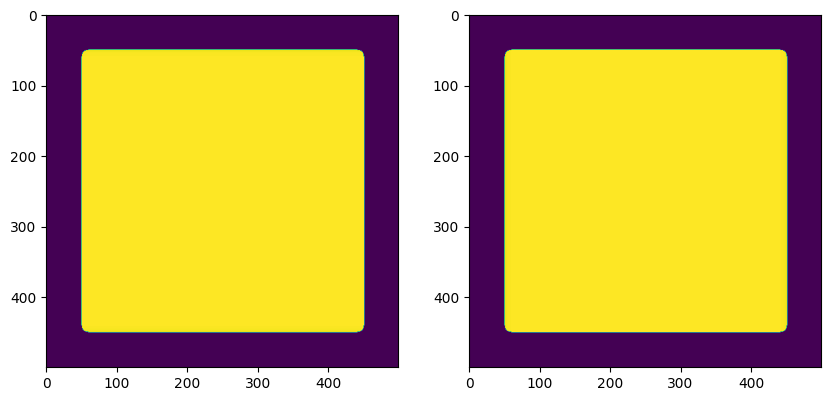

In [381]:
row_width_square, column_width_square = hole_width(square_image)

fig, ax = plt.subplots(1,2, figsize=(10,15))

ax[0].imshow(row_width_square)
ax[1].imshow(column_width_square)


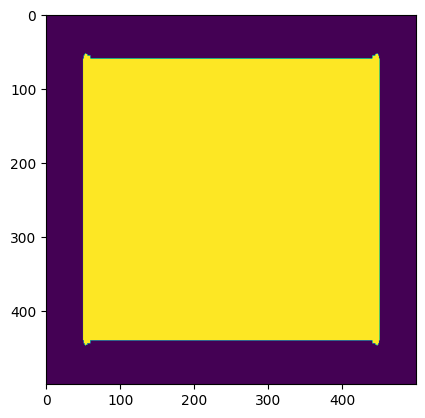

In [382]:
hole_mask = cv2.inRange(square_image, 255, 255).astype(np.float32)
object_width_horizontal = cv2.bitwise_and(hole_mask, row_width_square)
object_width_vertical = cv2.bitwise_and(hole_mask, column_width_square)

# wider_part = np.clip(object_width_horizontal >= object_width_vertical,0,1)
wider_part = np.clip(cv2.bitwise_or(np.clip(object_width_horizontal > object_width_vertical,0,1), np.clip(object_width_horizontal == object_width_vertical, 0, 1)), 0, 1)
wider_part[wider_part==1]=255
wider_part = hole_mask == wider_part
wider_part[wider_part==1]=255

plt.imshow(wider_part)



In [383]:
first_index = np.argwhere(object_width_horizontal[250,:] != 0)[0][0]
last_index = np.argwhere(object_width_horizontal[250,:] != 0)[-1][0]

last_index

450

In [126]:
np.argwhere(square_image[250,:] == 255)[-1][0]

450

In [384]:
# def bezier_parabola(self, line, t, prev, color_back, color_hole, dp2, dp3, percent):
# def bezier_parabola(line, t, color_hole, dp2, dp3, percent):
def bezier_parabola(line, t, color_hole, percent):

    point1 = (0, color_hole)
    new_color_hole = color_hole * (1 + percent/100)
    # new_color_hole = color_hole + (1 + percent/100)

    point4 = (len(line), new_color_hole)

    point3 = (len(line)//2, new_color_hole)
    point2 = (len(line)//2, color_hole)

    # point2 = (dp3[0]*len(line), dp3[1]*(new_color_hole - color_hole) + color_hole) # default: (len(line), color_back)
    # point3 = (dp3[0]*len(line), dp3[1]*(np.abs(color_hole - color_back)) - color_back)
    # point3 = (dp2[0]*len(line), dp2[1]*(new_color_hole - color_hole) + color_hole)

    x = point1[0]*(1-t)**3 + point2[0]*3*t*(1-t)**2 + point3[0]*3*t**2*(1-t) + point4[0]*t**3
    vals = point1[1]*(1-t)**3 + point2[1]*3*t*(1-t)**2 + point3[1]*3*t**2*(1-t) + point4[1]*t**3

    return x, vals

    



        # if prev == 0.0:
        #     point1 = (0, color_back)
        #     point4 = (len(line), color_hole)
        #     point2 = (dp3[0]*len(line), dp3[1]*(color_back - color_hole) + color_hole) # default: (len(line), color_back)
        #     # point3 = (dp3[0]*len(line), dp3[1]*(np.abs(color_hole - color_back)) - color_back)
        #     point3 = (dp2[0]*len(line), dp2[1]*(color_back - color_hole) + color_hole) #default: (0, color_hole)
        #     # point2 = (dp2[0]*len(line), dp2[1]*(np.abs(color_hole - color_back)) - color_back)

        # if prev == 255.0:
        #     point1 = (0, color_hole)
        #     point4 = (len(line), color_back)
        #     point3 = (dp3[0]*len(line), dp3[1]*(color_back - color_hole) + color_hole) # dafault: (0, color_back)
        #     # point3 = (dp3[0]*len(line), dp3[1]*(color_hole - color_back) + color_back)
        #     point2 = (dp2[0]*len(line), dp2[1]*(color_back - color_hole) + color_hole) # default: (len(line), color_hole)
        #     # point2 = (dp2[0]*len(line), dp2[1]*(color_hole - color_back) + color_back)
        # x = point1[0]*(1-t)**3 + point2[0]*3*t*(1-t)**2 + point3[0]*3*t**2*(1-t) + point4[0]*t**3
        # vals = point1[1]*(1-t)**3 + point2[1]*3*t*(1-t)**2 + point3[1]*3*t**2*(1-t) + point4[1]*t**3
        # return x, vals

In [131]:
dist_ = len(object_width_horizontal[250,first_index:last_index])
new_line = np.zeros(dist_*pixel_size, dtype=np.float32)

x, new_colors = bezier_parabola(new_line, np.linspace(0, 1, len(new_line)), 85.0, 100)
# x, new_angles = bezier_parabola(new_line, np.linspace(0, 1, len(new_line)), 0.0, 30)

reshaped_new_colors  = np.array(new_colors).reshape(-1, pixel_size)
new_angles = np.arctan(np.abs(np.gradient(new_colors)))
reshaped_new_angls  = np.array(new_angles).reshape(-1, pixel_size)

averages_angls = np.max(reshaped_new_angls, axis=1)
max_indices = np.argmax(reshaped_new_angls, axis=1)
averages_colors = reshaped_new_colors[np.arange(len(reshaped_new_colors)), max_indices]

4800


In [147]:
solv.mask_objects[0].angles_map[250,first_index:last_index] = averages_angls
cent = (last_index - first_index)//2
solv.mask_objects[0].color_map[250,first_index:first_index+cent] = averages_colors[:len(averages_colors)//2]
solv.mask_objects[0].color_map[250,first_index+cent:last_index] = averages_colors[len(averages_colors)//2-1::-1]


# solv.mask_objects[0].angles_map[first_index:first_index+object_width_horizontal[250,:].max()//2,250] = averages_angls
# solv.mask_objects[0].color_map[first_index:first_index+object_width_horizontal[250,:].max()//2, 250] = averages_colors


True

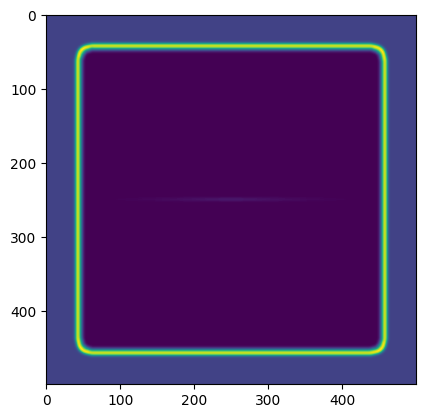

In [148]:
new_signal = solv.GetSignal(solv.mask_objects[0])

plt.imshow(new_signal)

cv2.imwrite('./signal_square_flashedhole.png', new_signal.astype(np.uint8))

In [551]:
percent = 100
flash_hole_horizontal = 'whole'    #   {'top’, 'center', 'bottom', 'whole'}
flash_hole_vertical = 'left'       #   {'left', 'center', 'right', 'whole'}
flash = 'vertical'                  #   {'vertical', 'horizontal'}

color_hole = 85.0

- починить то, что есть пиксели, где переход от засвета к границе четкий
надо сделать так, чтобы он был плавный, то есть может присваивать пискели засвета нескольких рядам из границы
- подумать, что делать с ситуацией когда вся поверхность должна быть засвечена одинаково
потому что брать среднее - получается хуево

50 43
51 43
52 42
53 42
54 42
55 42
56 41
57 41
58 41
59 41
60 40
61 40
62 40
63 40
64 40
65 40
66 40
67 40
68 40
69 40
70 40
71 40
72 40
73 40
74 40
75 40
76 40
77 40
78 40
79 40
80 40
81 40
82 40
83 40
84 40
85 40
86 40
87 40
88 40
89 40
90 40
91 40
92 40
93 40
94 40
95 40
96 40
97 40
98 40
99 40
100 40
101 40
102 40
103 40
104 40
105 40
106 40
107 40
108 40
109 40
110 40
111 40
112 40
113 40
114 40
115 40
116 40
117 40
118 40
119 40
120 40
121 40
122 40
123 40
124 40
125 40
126 40
127 40
128 40
129 40
130 40
131 40
132 40
133 40
134 40
135 40
136 40
137 40
138 40
139 40
140 40
141 40
142 40
143 40
144 40
145 40
146 40
147 40
148 40
149 40
150 40
151 40
152 40
153 40
154 40
155 40
156 40
157 40
158 40
159 40
160 40
161 40
162 40
163 40
164 40
165 40
166 40
167 40
168 40
169 40
170 40
171 40
172 40
173 40
174 40
175 40
176 40
177 40
178 40
179 40
180 40
181 40
182 40
183 40
184 40
185 40
186 40
187 40
188 40
189 40
190 40
191 40
192 40
193 40
194 40
195 40
196 40
197 40
198 40
199 40


True

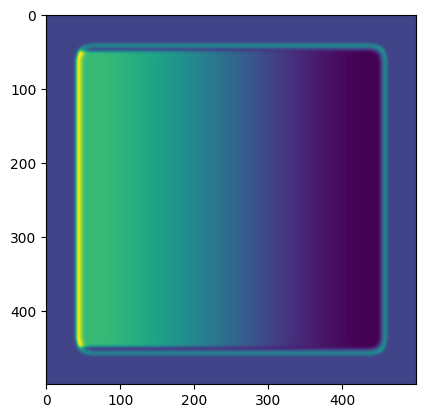

In [558]:
if flash == 'vertical':
    if flash_hole_horizontal == 'whole':
        row_start = np.argwhere(square_image == 255)[0][0]
        rows_count = len(np.unique(np.argwhere(square_image == 255)[:, 0]))-1
        row_end = np.unique(np.argwhere(square_image == 255)[:, 0])[rows_count]

    elif flash_hole_horizontal == 'top':
        row_start = np.argwhere(square_image == 255)[0][0]
        rows_count = len(np.unique(np.argwhere(square_image == 255)[:, 0]))-1
        row_end = np.unique(np.argwhere(square_image == 255)[:, 0])[rows_count//3]
    elif flash_hole_horizontal == 'bottom':
        row_end = np.argwhere(square_image == 255)[-1][0]
        rows_count = len(np.unique(np.argwhere(square_image == 255)[:, 0]))-1
        row_start = np.unique(np.argwhere(square_image == 255)[:, 0])[2*rows_count//3]
    elif flash_hole_horizontal == 'center':
        rows_count = len(np.unique(np.argwhere(square_image == 255)[:, 0]))-1
        row_start = np.unique(np.argwhere(square_image == 255)[:, 0])[rows_count//3]
        row_end = np.unique(np.argwhere(square_image == 255)[:, 0])[2*rows_count//3]
        
    for row in range(row_start, row_end):

        first_index = np.argwhere(object_width_horizontal[row,:] != 0)[0][0]
        last_index = np.argwhere(object_width_horizontal[row,:] != 0)[-1][0]

        dist_ = len(object_width_horizontal[row,first_index:last_index])
        new_line = np.zeros(dist_*pixel_size, dtype=np.float32)

        x, new_colors = bezier_parabola(new_line, np.linspace(0, 1, len(new_line)), color_hole, percent)

        reshaped_new_colors  = np.array(new_colors).reshape(-1, pixel_size)
        new_angles = np.arctan(np.abs(np.gradient(new_colors)))
        reshaped_new_angls  = np.array(new_angles).reshape(-1, pixel_size)

        averages_angls = np.max(reshaped_new_angls, axis=1)
        max_indices = np.argmax(reshaped_new_angls, axis=1)
        averages_colors = reshaped_new_colors[np.arange(len(reshaped_new_colors)), max_indices]

        solv.mask_objects[0].angles_map[row,first_index:last_index] = averages_angls

        if flash_hole_vertical == 'right':
            solv.mask_objects[0].color_map[row,first_index:last_index] =  averages_colors

            if solv.mask_objects[0].color_map[row,last_index:].min() < solv.mask_objects[0].color_map[row,last_index-1]:
                mensh = np.argwhere(solv.mask_objects[0].color_map[row,last_index:] < solv.mask_objects[0].color_map[row,last_index-1])
                solv.mask_objects[0].color_map[row,last_index:][mensh] = solv.mask_objects[0].color_map[row,last_index-1]
           
        elif flash_hole_vertical == 'left':
            solv.mask_objects[0].color_map[row,first_index:last_index] =  averages_colors[::-1]
            border_indexes = np.argwhere(solv.mask_objects[0].mask[row,:]==128)

            # тут делаем яркость левой границы больше из-за засвета, дальше засвет не ведем
            # уточнить, надо ли
            if solv.mask_objects[0].color_map[row,first_index-1:border_indexes[0][0]:-1].min() < solv.mask_objects[0].color_map[row,first_index]:
                mensh = np.argwhere(solv.mask_objects[0].color_map[row,first_index-1:border_indexes[0][0]:-1] < solv.mask_objects[0].color_map[row,first_index])
                solv.mask_objects[0].color_map[row,first_index-1:border_indexes[0][0]:-1][mensh] = solv.mask_objects[0].color_map[row,first_index]
        elif flash_hole_vertical == 'center':
            cent = (last_index - first_index)//2
            solv.mask_objects[0].color_map[row, first_index:first_index+cent] = averages_colors[:len(averages_colors)//2]
            solv.mask_objects[0].color_map[row, first_index+cent-1:last_index] = averages_colors[len(averages_colors)//2::-1]

elif flash == 'horizontal':
    if flash_hole_vertical == 'whole':
        col_count = len(np.unique(np.argwhere(square_image == 255)[:, 1]))-1
        col_end = np.unique(np.argwhere(square_image == 255)[:, 1])[col_count]
        col_start = np.unique(np.argwhere(square_image == 255)[:, 1])[0]

    elif flash_hole_vertical == 'left':
        col_count = len(np.unique(np.argwhere(square_image == 255)[:, 1]))-1
        col_end = np.unique(np.argwhere(square_image == 255)[:, 1])[col_count//3]
        col_start = np.unique(np.argwhere(square_image == 255)[:, 1])[0]
    elif flash_hole_vertical == 'right':
        col_count = len(np.unique(np.argwhere(square_image == 255)[:, 1]))-1
        col_start = np.unique(np.argwhere(square_image == 255)[:, 1])[2*col_count//3]
        col_end = np.unique(np.argwhere(square_image == 255)[:, 1])[col_count]

    elif flash_hole_vertical == 'center':
        col_count = len(np.unique(np.argwhere(square_image == 255)[:, 1]))-1
        col_start = np.unique(np.argwhere(square_image == 255)[:, 1])[col_count//3]
        col_end = np.unique(np.argwhere(square_image == 255)[:, 1])[2*col_count//3]

    for col in range(col_start, col_end):

        first_index = np.argwhere(object_width_horizontal[:,col] != 0)[0][0]
        last_index = np.argwhere(object_width_horizontal[:,col] != 0)[-1][0]

        dist_ = len(object_width_horizontal[first_index:last_index, col])
        new_line = np.zeros(dist_*pixel_size, dtype=np.float32)
        x, new_colors = bezier_parabola(new_line, np.linspace(0, 1, len(new_line)), color_hole, percent)
        reshaped_new_colors  = np.array(new_colors).reshape(-1, pixel_size)
        new_angles = np.arctan(np.abs(np.gradient(new_colors)))
        reshaped_new_angls  = np.array(new_angles).reshape(-1, pixel_size)

        averages_angls = np.max(reshaped_new_angls, axis=1)
        max_indices = np.argmax(reshaped_new_angls, axis=1)
        averages_colors = reshaped_new_colors[np.arange(len(reshaped_new_colors)), max_indices]

        solv.mask_objects[0].angles_map[first_index:last_index, col] = averages_angls
        if flash_hole_horizontal == 'center':
            cent = (last_index - first_index)//2
            solv.mask_objects[0].color_map[first_index:first_index+cent, col] = averages_colors[:len(averages_colors)//2]
            solv.mask_objects[0].color_map[first_index+cent-1:last_index, col] = averages_colors[len(averages_colors)//2::-1]
        elif flash_hole_horizontal == 'bottom':
            solv.mask_objects[0].color_map[first_index:last_index, col] =  averages_colors
            if solv.mask_objects[0].color_map[last_index:, col].min() < solv.mask_objects[0].color_map[last_index-1, col]:
                mensh = np.argwhere(solv.mask_objects[0].color_map[last_index:last_index+1, col] < solv.mask_objects[0].color_map[last_index-1, col])
                solv.mask_objects[0].color_map[last_index:last_index+1, col][mensh] = solv.mask_objects[0].color_map[last_index-1, col]

        elif flash_hole_horizontal == 'top':
            solv.mask_objects[0].color_map[first_index:last_index, col] =  averages_colors[::-1]
            if solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col].min() < solv.mask_objects[0].color_map[first_index, col]:
                mensh = np.argwhere(solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col] < solv.mask_objects[0].color_map[first_index, col])
                solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col][mensh] = solv.mask_objects[0].color_map[first_index, col]

        if flash_hole_vertical == 'left': solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col_start-1] = solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col_start]
        if flash_hole_vertical == 'right': solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col_end+1] = solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col_end]




new_signal = solv.GetSignal(solv.mask_objects[0])

plt.imshow(new_signal)

cv2.imwrite('./signal_square_flashedhole.png', new_signal.astype(np.uint8))
        
        

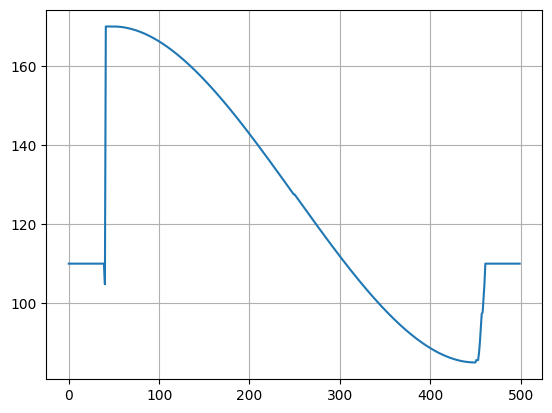

In [554]:
# plt.plot(solv.mask_objects[0].angles_map[250,:])
plt.plot(solv.mask_objects[0].color_map[250,:])
plt.grid()


Text(0.5, 1.0, 'Срез посередине фигуры с засветом справа')

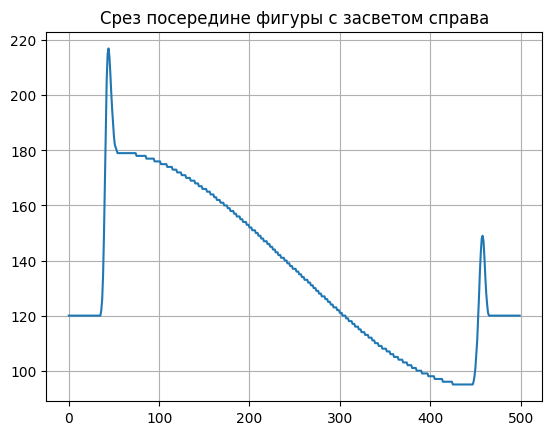

In [555]:
plt.plot(solv.mask_objects[0].signal[250,:])
plt.grid()
plt.title('Срез посередине фигуры с засветом справа')

In [556]:
# a = random.randint(40, 50)
# b = random.randint(5, 10)
a = 50
b = 6
m = Gamma(torch.tensor([a], dtype=torch.float32), torch.tensor([b], dtype=torch.float32))
sample = m.sample()
sample.item()

clean = torch.Tensor(new_signal)
noisy = clean +  m.sample()* torch.randn(clean.shape)
res_noisy = clean + m.sample()* torch.randn(clean.shape)

cv2.imwrite('./raw_square_flashedhole.png', np.clip(res_noisy.numpy(),0,255).astype(np.uint8))


True

Text(0.5, 1.0, 'Срез посередине шумной фигуры с засветом слева')

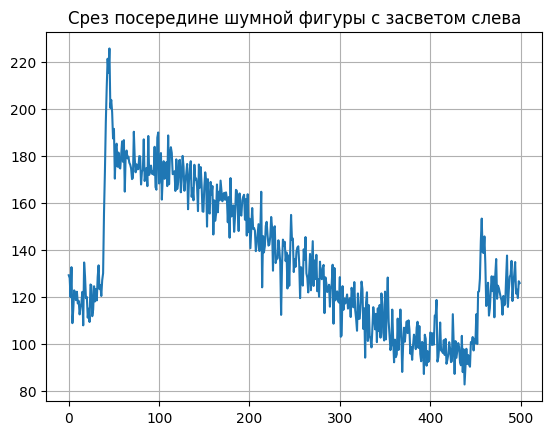

In [557]:
plt.plot(res_noisy[250,:])
plt.grid()
plt.title('Срез посередине шумной фигуры с засветом слева')
